In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [20]:
# load runs from experiments
experiments = []
# experiments += ['jun24_cfr_gamut_6'] 
# experiments += ['jun24_cfr_gamut_7']
# experiments += ['jun26_port']
experiments += ['jun28_port_2']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 225 runs


In [21]:
def make_combo_specific(evaluation):
    r = dict()
    for k,v in evaluation.samples.items():
        if isinstance(v, dict):
            for k2, v2 in v.items():
                r[f'{k}_{k2}'] = v2
        else:
            r[k] = v
    del r['rewards']

    c_df = pd.DataFrame(r)
    type_columns = [c for c in c_df if 'types_' in c]
    c_df['combo'] = list(map(tuple, c_df[type_columns].values))
    mean_lengths = c_df.groupby('combo')['auction_lengths'].mean()
    ### A given type combo where tie-breaking (non-final) seems to matter
    for v in mean_lengths.values:
        if not v.is_integer() and v < 4:
            print("FOUND YOU", v)
            return True
    return False


In [22]:
records = []

for run in tqdm(runs):
    try:
        checkpoints =  run.equilibriumsolverruncheckpoint_set.all()
        if len(checkpoints) == 0:
            print(f"No checkpoints for {run}!")
        e = checkpoints.last()
        evaluation = e.get_modal_eval()
        record = dict(run=run.name, game=run.game.name, t=e.t, modal_nash_conv=evaluation.nash_conv, walltime=e.walltime, alg=get_algorithm_from_run(run), rewards=evaluation.mean_rewards, improvements=evaluation.player_improvements)

        x = dict(run.config)
        # del x['seed']
        del x['use_wandb']
        del x['solver_type']
        record.update(x)


        ### For Greg: convergence test
#             if run.config['seed'] != 100:
#                 continue
#             try:
#                 game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False, load_policy=True)
#             except Exception as e:
#                 print(f"Skipping run {run.name} because of error {e}")
#                 continue

#             total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test
#             record['total_entropy'] = total_entropy
        ### End


        records.append(record)
    except Exception as e:
        print(f"Run {run} facing error {e}")
        continue

 84%|████████▍ | 189/225 [05:51<06:29, 10.83s/it]

Run jun26_jun26_2_no_activity-cfr_port_2external_plus-102 (jun28_port_2) facing error Evaluation matching query does not exist.


100%|██████████| 225/225 [08:29<00:00,  2.27s/it]

No checkpoints for jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg_plus-102 (jun28_port_2)!
Run jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg_plus-102 (jun28_port_2) facing error 'NoneType' object has no attribute 'get_modal_eval'
No checkpoints for jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg_plus-101 (jun28_port_2)!
Run jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg_plus-101 (jun28_port_2) facing error 'NoneType' object has no attribute 'get_modal_eval'
No checkpoints for jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg-100 (jun28_port_2)!
Run jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg-100 (jun28_port_2) facing error 'NoneType' object has no attribute 'get_modal_eval'
No checkpoints for jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg-101 (jun28_port_2)!
Run jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg-101 (jun28_port_2) facing error 'NoneType' object has no attribute 'get_modal_eval'
No checkpoints for jun26_jun26_1_no_activity-cfr_port_2o

In [27]:
df_time = pd.DataFrame.from_records(records)
# df_time['variant'] = list(map(str,(zip(df_time.sampling_method, df_time.linear_averaging, df_time.regret_matching_plus, df_time.explore_prob, df_time.tremble_prob, df_time.regret_init, df_time.regret_init_strength))))
df_time['variant'] = list(map(str,(zip(df_time.sampling_method, df_time.linear_averaging, df_time.regret_matching_plus))))

In [66]:
modal_eval = runs[206].equilibriumsolverruncheckpoint_set.order_by('t').last().get_modal_eval()
modal_eval.nash_conv_runtime

6.7916600704193115

In [64]:
runs[20]

<EquilibriumSolverRun: jun26_jun26_1_grace_period-cfr_port_2external_plus-100 (jun28_port_2)>

In [58]:
runs[0]

<EquilibriumSolverRun: jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg-101 (jun28_port_2)>

In [68]:
df_time.iloc[-1].run

'jun26_jun26_1_no_activity-cfr_port_2outcome_lin_avg_plus-100'

In [59]:
'jun26_jun26_3_no_activity-cfr_port_2external_plus-102' in df_time.run.values

False

In [41]:
df_time.run.values

array(['jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg-101',
       'jun26_jun26_1_high_speed-cfr_port_2external_plus-101',
       'jun26_jun26_1_high_speed-cfr_port_2external_plus-100',
       'jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg-102',
       'jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg-100',
       'jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg_plus-102',
       'jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg_plus-100',
       'jun26_jun26_1_high_speed-cfr_port_2outcome_lin_avg_plus-101',
       'jun26_jun26_1_high_speed-cfr_port_2external_plus-102',
       'jun26_jun26_1_base-cfr_port_2outcome_lin_avg_plus-100',
       'jun26_jun26_1_base-cfr_port_2outcome_lin_avg_plus-102',
       'jun26_jun26_1_base-cfr_port_2outcome_lin_avg_plus-101',
       'jun26_jun26_1_base-cfr_port_2outcome_lin_avg-102',
       'jun26_jun26_1_base-cfr_port_2outcome_lin_avg-100',
       'jun26_jun26_1_base-cfr_port_2external_plus-100',
       'jun26_jun26_1_base-cfr_port_2ou

In [ ]:
# plt.figure(figsize=(9,9))

# # Does longer = better?
# dt = df_time.query('~modal_nash_conv.isnull()')
# dt = dt.groupby('variant').filter(lambda grp: len(grp) > 25)
# dt = dt.query('seed == 100 and t > 1_000')
# dt['port'] = dt['run'].str.contains('port')
# # TODO: Limit to same comparison
# dt = dt.groupby(['game', 'variant']).filter(lambda grp: len(grp) == 2)
# # dt.groupby(['variant', 'port'])['modal_nash_conv'].describe()
# dt.pivot(values=['modal_nash_conv'], columns=['port'], index=['variant', 'game']).plot(kind='scatter', x=("modal_nash_conv", False), y=("modal_nash_conv", True))
# plt.axline((0, 0), slope=1)

# # dt.groupby(['variant', 'game'])['modal_nash_conv']

In [ ]:
# df_time.groupby(['sampling_method', 'linear_averaging', 'regret_matching_plus', 'explore_prob'])['modal_nash_conv'].mean()
# Why are 25 rows missing?

# df_time.pivot(['sampling_method', 'linear_averaging', 'regret_matching_plus', 'explore_prob'], index='run', values='modal_nash_conv')


In [28]:
df_time.query("""variant == "('outcome', True, True, nan, nan, 'straightforward_clock', 100.0)" and t > 1000""")['modal_nash_conv'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: modal_nash_conv, dtype: float64

In [ ]:
df_time.groupby('game').size()

In [67]:
num_variants = df_time['variant'].nunique()
df_all = df_time.groupby('game').filter(lambda grp: len(grp) == 18 and grp['modal_nash_conv'].isnull().sum() == 0) # Only look at games where ALL of them had runs and everyone finished NashConv calcs for fairness


In [57]:
df_all.groupby(['variant'])['modal_nash_conv'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max


In [68]:
#### PORTFOLIO LOGIC ####
portfolio = []
algs = df_time['variant'].unique()
df_port = df_all[['variant', 'game', 'modal_nash_conv']].rename(columns={'variant': 'alg', 'game': 'instance', 'modal_nash_conv': 'runtime'})

# Greedy portfolio agg
for i in range(5):
    alg2score = dict()
    for alg in algs:
        new_port = portfolio + [alg]
        score = df_port.query('alg in @new_port').groupby('instance')['runtime'].min().sum()
        alg2score[alg] = score

    best_alg = pd.Series(alg2score).sort_values().idxmin()
    best_score = pd.Series(alg2score).sort_values().min()
    print(i, best_alg, best_score)
    portfolio.append(best_alg)



0 ('external', nan, True, nan, nan, nan, nan) 89.64118749999997
1 ('outcome', True, True, nan, nan, nan, nan) 47.383837499999956
2 ('outcome', True, nan, nan, nan, nan, nan) 39.95759999999996
3 ('outcome', True, True, nan, nan, 'straightforward_clock', 100.0) 33.80759999999998
4 ('external', True, nan, nan, nan, nan, nan) 30.080400000000015


In [ ]:
df_heatmap = df_all[['variant', 'modal_nash_conv', 'game']].pivot_table(
    values='modal_nash_conv',
    columns=['game'],
    index='variant'
)
df_heatmap_norm=(df_heatmap / df_heatmap.max())
sns.heatmap(df_heatmap_norm, annot=True, cmap='Blues')

In [ ]:
df_all[['variant', 'modal_nash_conv', 'game']].pivot_table

In [ ]:
z = df_all.query(""" variant == "('outcome', True, True, 0.4)" """)
(z['modal_nash_conv'] / z['rewards'].apply(sum))

In [ ]:
df_time['reward_sum'] = df_time['rewards'].apply(lambda x: sum(x))
df_time['nash_conv_frac'] = df_time['modal_nash_conv'] / df_time['reward_sum']

In [ ]:
df_time.loc[df_time.groupby('run')['t'].idxmax()]

In [ ]:
# TODO: I only want the LAST nashconv, this is dumb
# df.query('~modal_nash_conv.isnull() and alg == "cfr_outcome"').groupby('run')['modal_nash_conv'].describe().sort_values('mean', ascending=False).head(20)

In [ ]:
df.loc[df.groupby('run')['t'].idxmax()].set_index('run')['nash_conv_frac'].sort_values(ascending=False).describe() # Why 69 and not 75?
# In summary, NashConv is usually less than 10%. Hopefully this is also true on a per-player basis. There are a 13 bad cases with > 10%, 7 NaN, and 49 "good"

In [ ]:
# What if you took the "best" t? Can get up to 53 that way... 
(df.groupby('run')['nash_conv_frac'].min() < 0.1).sum()

In [ ]:
plt.figure(figsize=(16, 9))
plt_df = df_time.query('~modal_nash_conv.isnull() and alg == "cfr_external"').groupby('run').filter(lambda grp: len(grp) > 1).sort_values('t')
for r, sub_df in plt_df.groupby('run'):
    # display(sub_df)
    plt.plot(sub_df['t'].values, sub_df['modal_nash_conv'].values)
# plt.legend()
# plt.semilogy()
# sns.lineplot(data=plt_df, y='modal_nash_conv', x='t', hue='run', legend=False)

# How many lines are changing downwards? Why is almost no progress ever made after 500K iterations?


In [ ]:
plt_df['run'].values

In [ ]:
deltas = df.loc[df.groupby('run')['t'].idxmin()].set_index('run')['modal_nash_conv'] - df.loc[df.groupby('run')['t'].idxmax()].set_index('run')['modal_nash_conv']
deltas[deltas > 0]
# Most of the time, the deltas are very weakly positive. Can definitely move in either direction

In [ ]:
len(e.get_model()._infostates)

In [ ]:
dir(e)

# Analyze runs

In [5]:
# empirical = True
# USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False, load_policy=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

#         if USE_MODAL:
#             evaluation = final_checkpoint.get_modal_eval()
#             # if make_combo_specific(evaluation):
#             #     print(run.name)
#         else:
#             evaluation = final_checkpoint.get_old_eval()
            
            
        # total_entropy = analyze_samples(final_checkpoint.get_old_eval().samples, game)['total_entropy'] # Use old eval since modal is stupid for this and it's a convergence test

        # if empirical: 
        #     history_dists = empirical_history_distribution(final_checkpoint.get_old_eval()) # Always use the old eval here
        #     history_entropies = [scipy.stats.entropy(list(history_dists.loc[type_combo].values)) for type_combo in np.unique(history_dists.index.get_level_values(0))]
        # else:
        #     history_dists = compute_per_type_combo(history_distribution, policy, game, min_prob=0.01, history_type='processed')
        #     history_entropies = [scipy.stats.entropy(list(history_dists[type_combo].values())) for type_combo in history_dists]

        # try:
        #     # TODO: Broken until you remove "Tremble" agents
        #     _, _, approx_nash_conv = find_best_checkpoint(run)
        # except:
        #     # TODO: Fix bug where this actually happens because your BRs failed to do better and you have an Empirical Nash Conv of 0, very different from NaN
        #     # ev_df = parse_run(run, None)
        #     # display(ev_df)
        #     approx_nash_conv = np.nan

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'activity_policy': ActivityPolicy(game.auction_params.activity_policy).name,
            'undersell_policy': UndersellPolicy(game.auction_params.undersell_policy).name,
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later
            'grace_rounds': game.auction_params.grace_rounds,

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # metrics from eval
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        evaluation = final_checkpoint.get_modal_eval()
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'player_improvements_{i}'] = evaluation.player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'player_improvements_frac_{i}'] = (evaluation.player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan
        record.update(**analyze_samples(evaluation.samples, game))

        # Slowwwwww you may want to comment this out when not using it
#         start = time.time()
#         c = final_checkpoint.equilibrium_solver_run.config
#         cfr = c.get('solver_type') == 'cfr'
#         env_and_policy = ppo_db_checkpoint_loader(final_checkpoint, cfr=cfr)
#         for player in range(game.num_players()):
#             env_and_policy.agents[player] = ModalAgentDecorator(env_and_policy.agents[player])
#         modal_policy = env_and_policy.make_policy()
        
#         worked, nc = time_bounded_run(30, nash_conv, game, modal_policy)
#         if not worked:
#             print("Aborted run because time")
#         record['nash_conv'] = nc if worked else np.nan
#         record['nash_conv_time'] = time.time() - start
#         print(time.time() - start)
        records.append(record)
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        raise e
print(len(records))

100%|██████████| 104/104 [00:49<00:00,  2.08it/s]

104


In [7]:
df = pd.DataFrame.from_records(records)
# df['imperfect'] = df['game_name'].str.contains('imperfect')


In [8]:
df['variant'] = list(map(str,(zip(df.information_policy, df.clock_speed, df.activity_policy, df.undersell_policy))))
palette = dict()

colors = ['red', 'blue', 'magenta', 'green', 'orange']

for i, v in enumerate(df['variant'].unique()):
    palette[v] = colors[i]

In [9]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 

In [11]:
### Remove bad entries
good_thresh = 0.1
good_thresh_abs = 5
df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
# df_plt = df.query(f'player_improvements_frac_0 < {good_thresh} and player_improvements_frac_1 < {good_thresh}')
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
print(len(df), len(df_plt))

(df.groupby('game_name').size() - df_plt.groupby('game_name').size()).sort_values()

104 69


game_name
jun26/jun26_1_high_speed.json      0.0
jun26/jun26_3_base.json            0.0
jun26/jun26_3_medium_speed.json    0.0
jun26/jun26_4_high_speed.json      0.0
jun26/jun26_2_high_speed.json      1.0
jun26/jun26_4_base.json            1.0
jun26/jun26_4_grace_period.json    1.0
jun26/jun26_0_high_speed.json      3.0
jun26/jun26_0_medium_speed.json    4.0
jun26/jun26_2_base.json            7.0
jun26/jun26_1_base.json            NaN
jun26/jun26_1_grace_period.json    NaN
dtype: float64

In [ ]:
for i in range(2):
    df[f'rewards_{i}'] = df['rewards'].apply(lambda x: x[i])


In [ ]:
df['rewards_0'].describe(), df['rewards_1'].describe()

In [ ]:
df[['rewards']].explode

In [ ]:
df['rewards'].explode

In [ ]:
df['rewards'].explode

In [ ]:
len(df_plt), len(df)

In [ ]:
# df.query('activity_policy == "OFF"')['nash_conv_frac']
df.query('undersell_policy == "UNDERSELL" and information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 ')[['t', 'nash_conv', 'nash_conv_frac']]

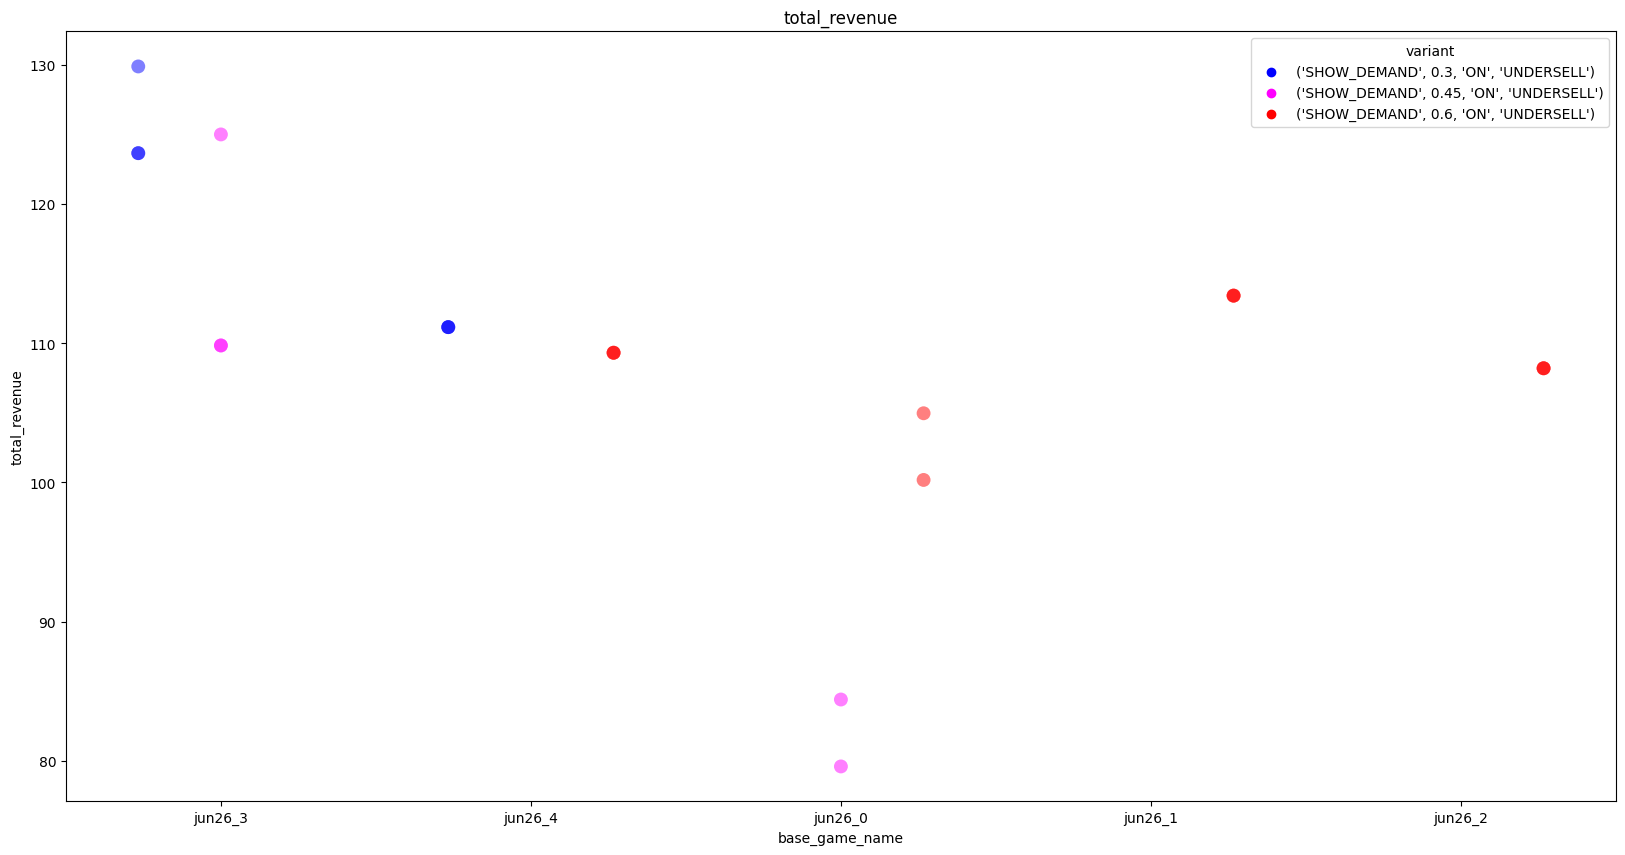

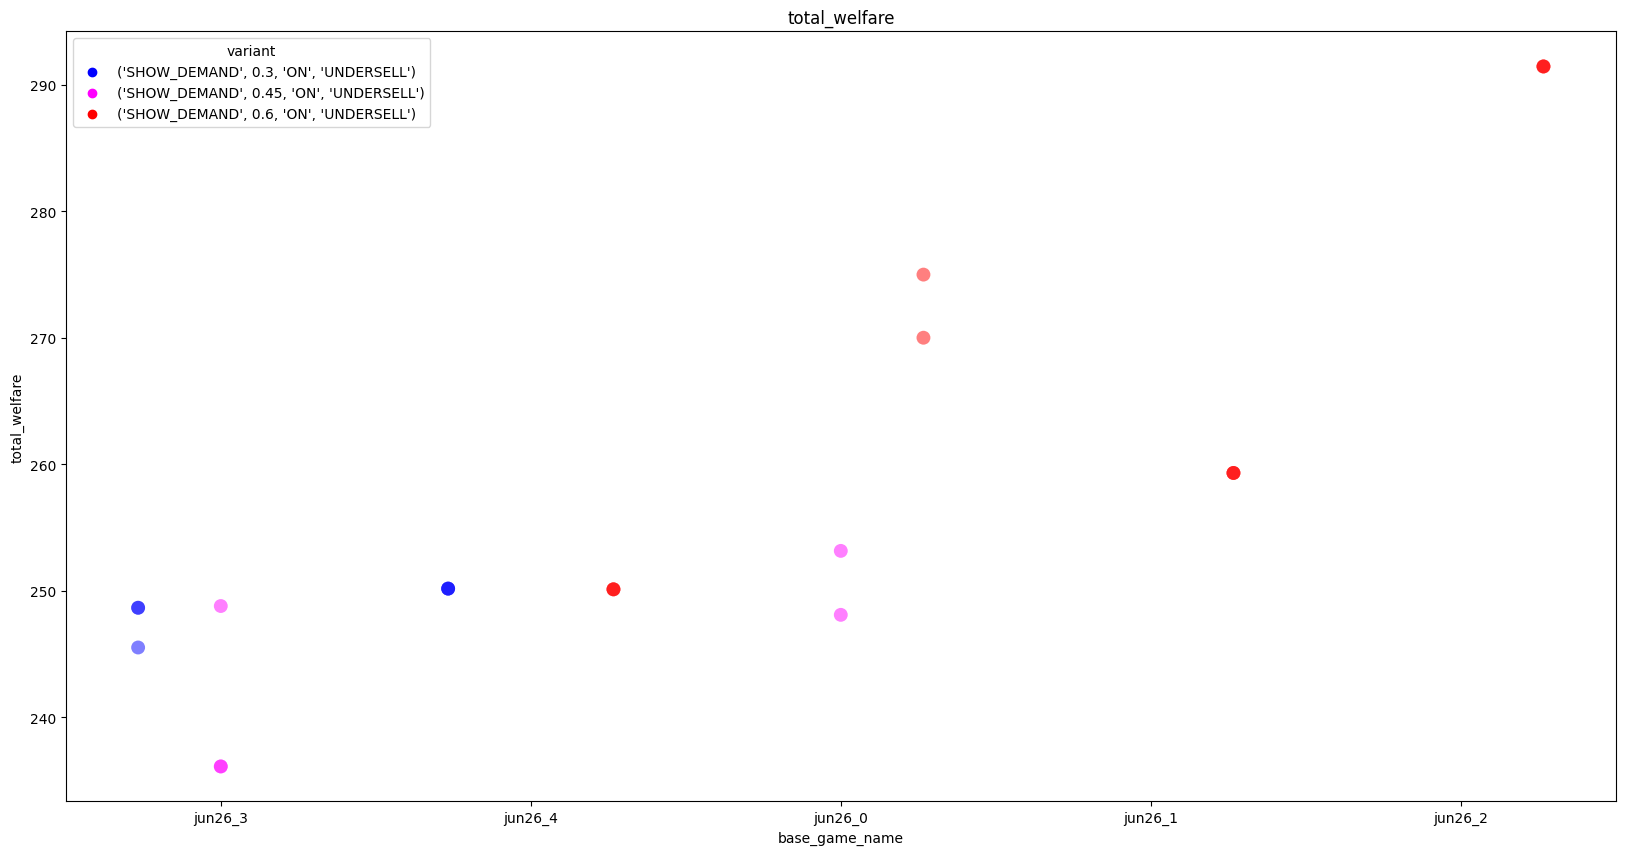

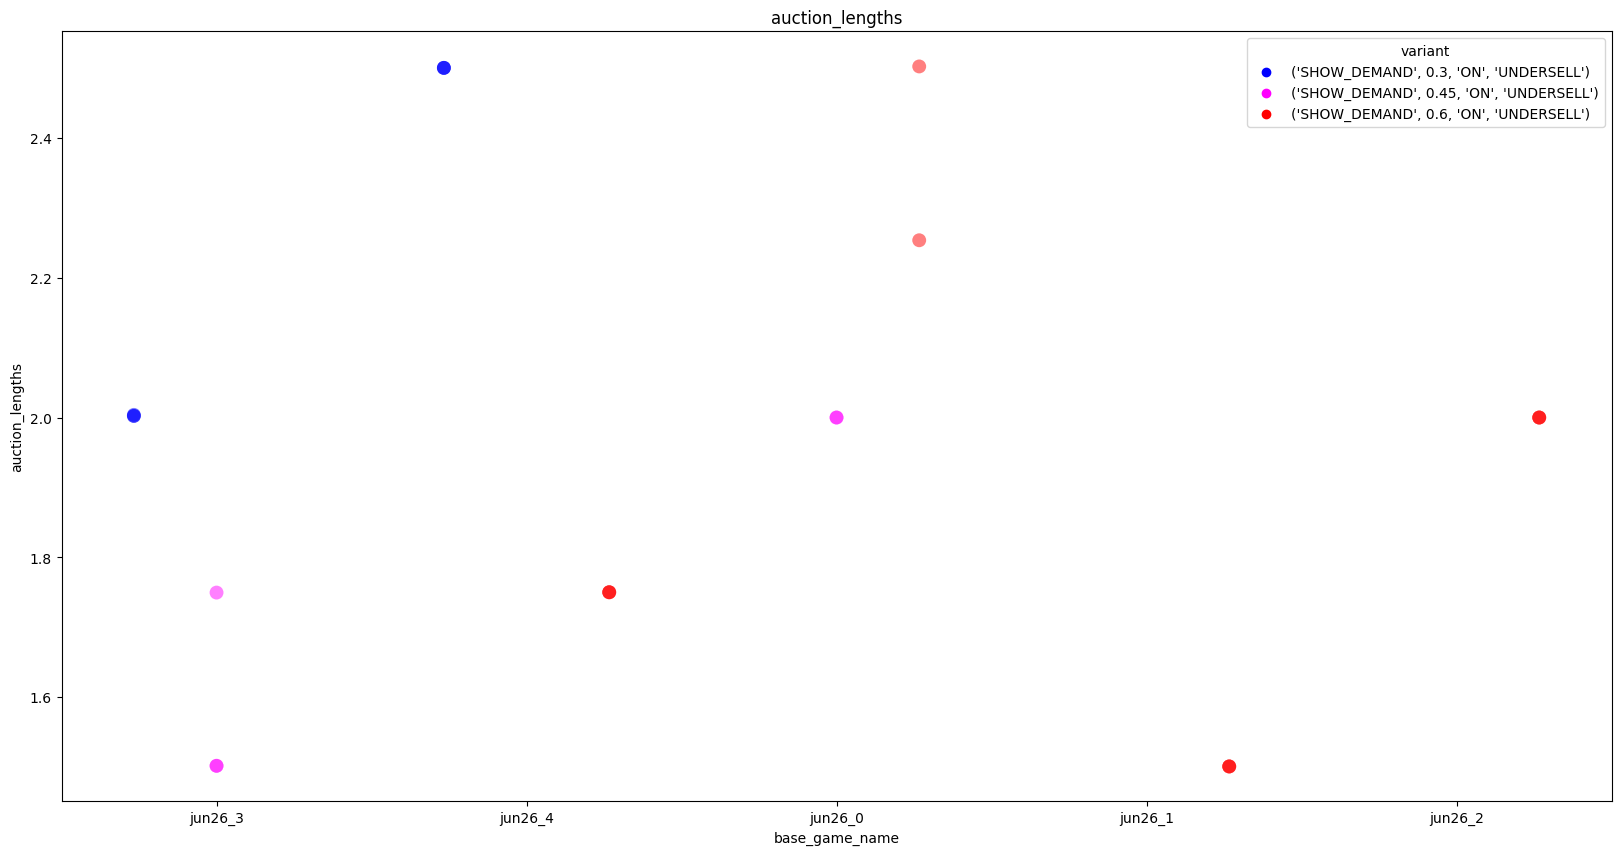

In [14]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# Vanilla for clock
box_df = box_df.query('information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1')

# # Check undersell
# box_df = box_df.query('information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3')

# # Check activity
# box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3')

box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df.query(f'config == "{config}"'), **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        #     # ax = sns.stripplot(data=box_df.query('alg.str.contains("PPO") and imperfect'), marker='X', **strip_kwargs)
        #     # ax = sns.stripplot(data=box_df.query('alg.str.contains("cfr")'), marker='^', **strip_kwargs)
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [ ]:
df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3')[['nash_conv_frac']]

In [ ]:


# ### Code to rerun evals for a failed experiment
# from open_spiel.python.examples.ubc_dispatch import dispatch_eval_database
# exp = 'jun5outcome'

# for e in Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp):
#     experiment_name = e.checkpoint.equilibrium_solver_run.experiment.name
#     run_name = e.checkpoint.equilibrium_solver_run.name
#     t = e.checkpoint.t
#     dispatch_eval_database(experiment_name, run_name, t, None, None)
# print(Evaluation.objects.filter(checkpoint__equilibrium_solver_run__experiment__name=exp).delete())

In [ ]:
df.query('alg == "PPO"').groupby(['experiment', 'imperfect']).mean()

In [ ]:
records = []

for run in tqdm(runs):
    try:
        ev_df = parse_run(run, expected_additional_br=0)
        if ev_df is None:
            continue
        ev_df = ev_df.query('name == "modal"')
        if not ev_df.empty:
            val = ((ev_df['Regret'] / ev_df['Baseline']).mean() * 100)
            record = dict(val=val, alg=get_algorithm_from_run(run), game=run.game.name)
            records.append(record)
    except KeyError as e:
        continue
val_df = pd.DataFrame.from_records(records)

In [ ]:
# val_df.groupby(['game', 'alg']).describe()
val_df.groupby(['game', 'alg']).describe()

In [ ]:
# import open_spiel.python.examples.ubc_dispatch as dispatch
# for run in runs:
#     try:
#         game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False)
#     except:
#         print("Skipping", run)
#         continue
#     final_checkpoint.bestresponse_set.all().delete()
#     for player in range(game.num_players()):
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'modal') 
#         dispatch.dispatch_eval_database(run.experiment.name, run.name, final_checkpoint.t, player, 'tremble')  

In [ ]:
### This is the cell you run when you want to rerun evals 
bad_count = 0
for run in tqdm(runs):
    # print(run)
    try:
        game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=False, load_policy=False)
    except Exception as e:
        print(f"Skipping run {run.name} because of error {e}")
        continue

    try:
        ev = final_checkpoint.get_modal_eval()
        if not pd.isnull(ev.nash_conv):
            continue
        else:
            ev.delete()
    except Exception as e:
        ev = None

    bad_count += 1
    br_mapping = {p: 'modal' for p in range(2)}
    dispatch.dispatch_eval_database(final_checkpoint.t, run.experiment.name, run.name, str(br_mapping))
    
print(bad_count)

In [ ]:
game = pyspiel.load_game('python_clock_auction')